Camera Calibration with OpenCV
===



In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = mpimg.imread(fname)
#     img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(50)

cv2.destroyAllWindows()

In [2]:
ret, mtx, dist, rvecs, tvecs  = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

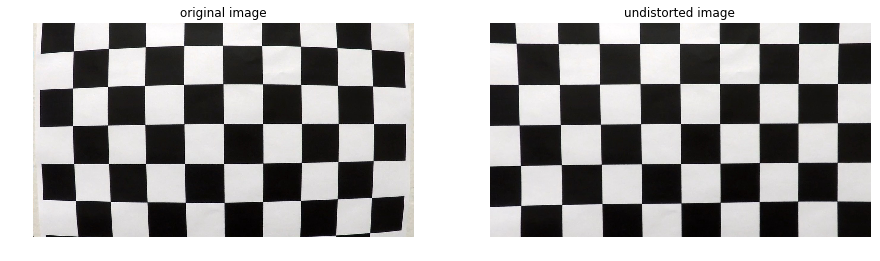

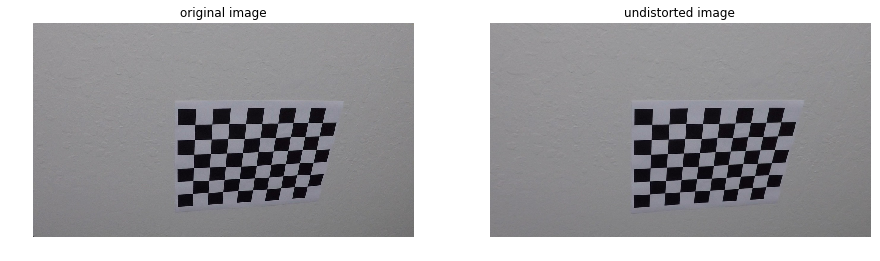

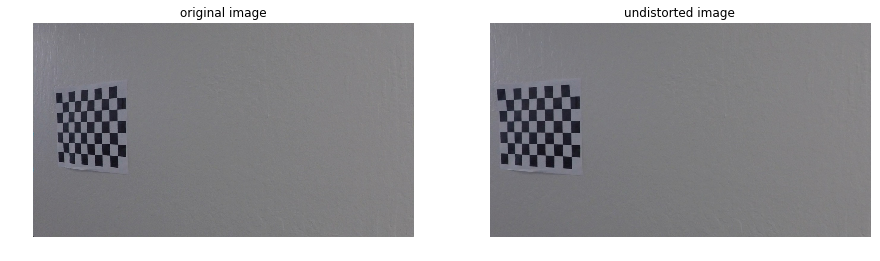

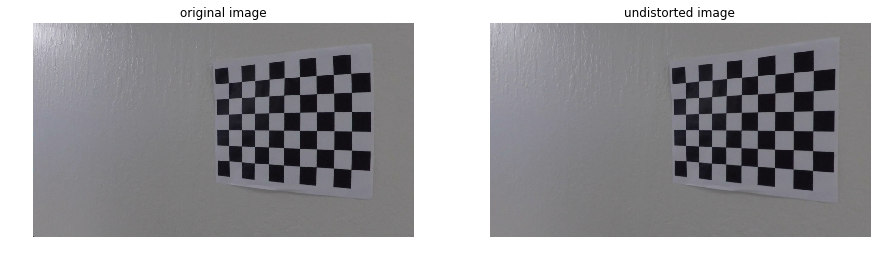

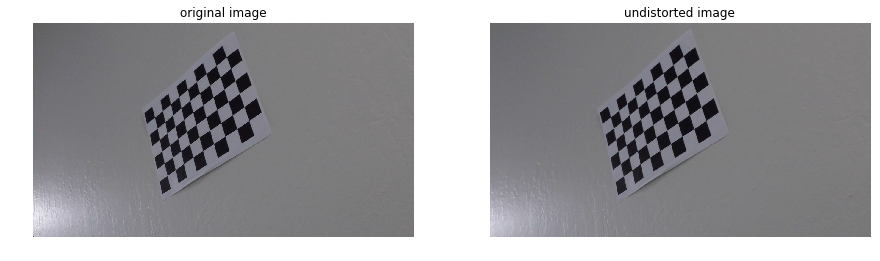

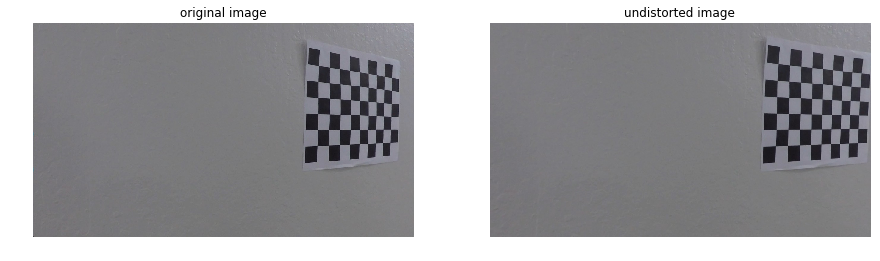

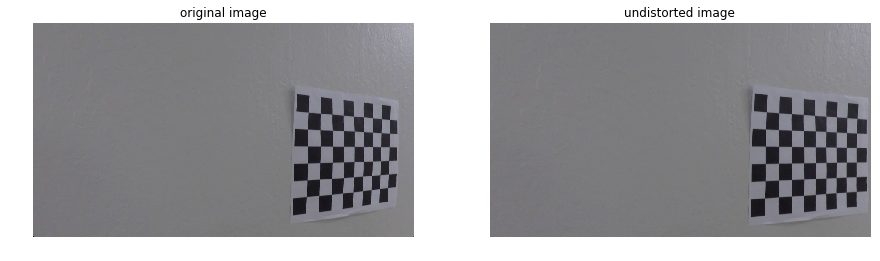

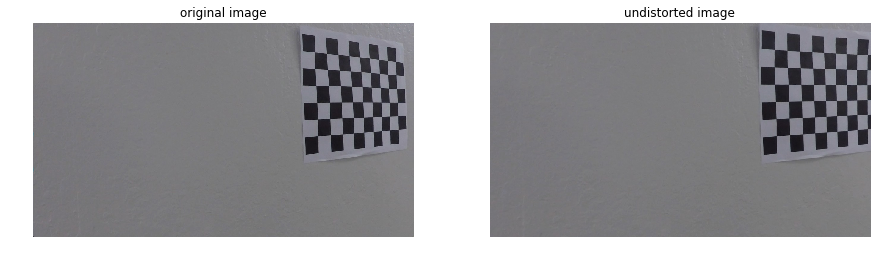

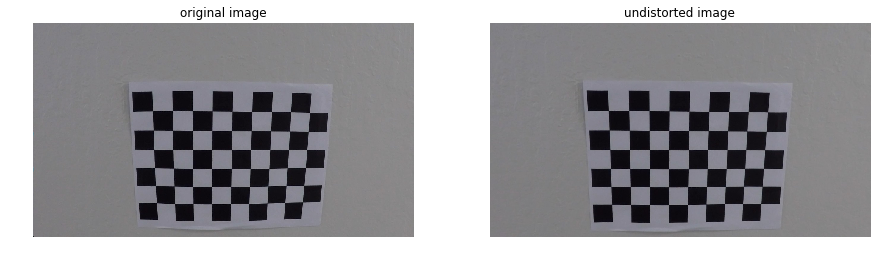

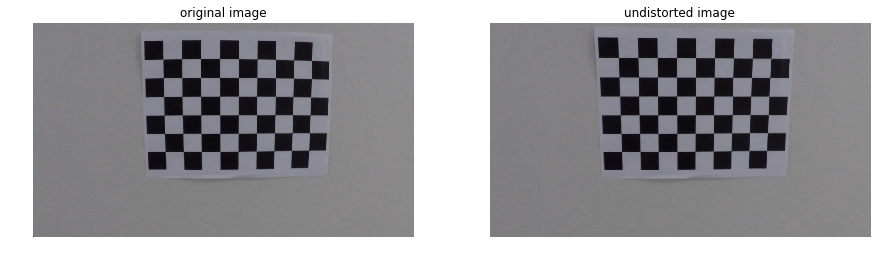

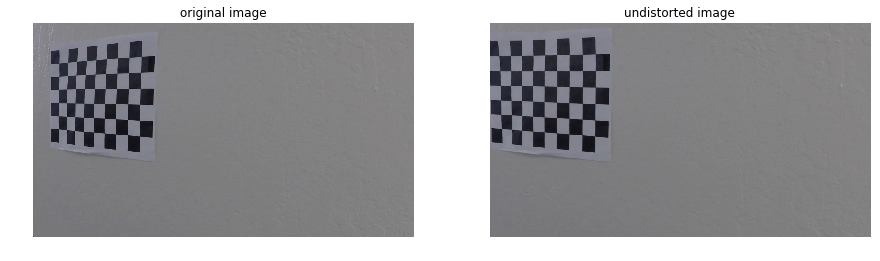

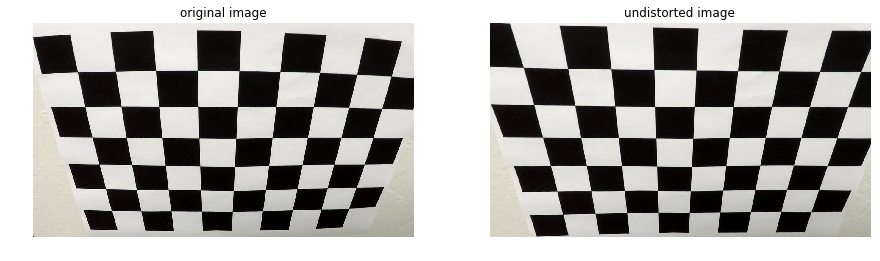

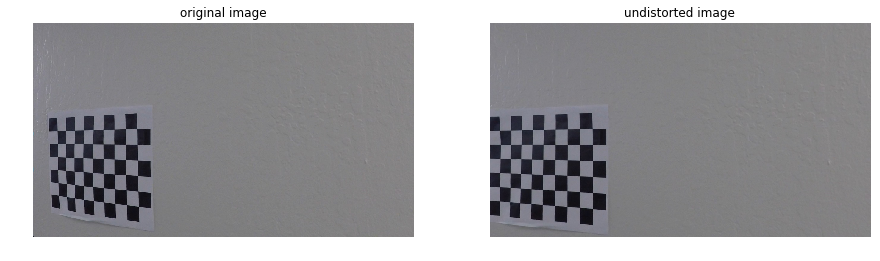

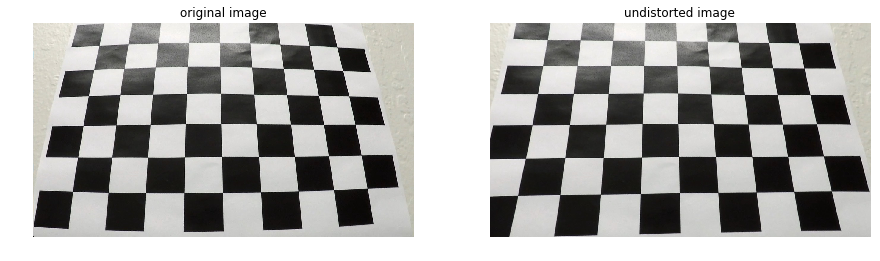

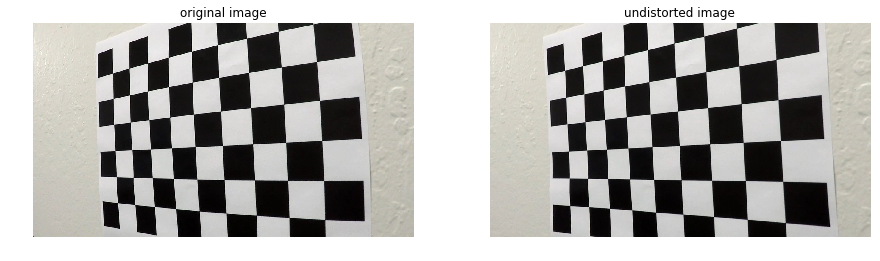

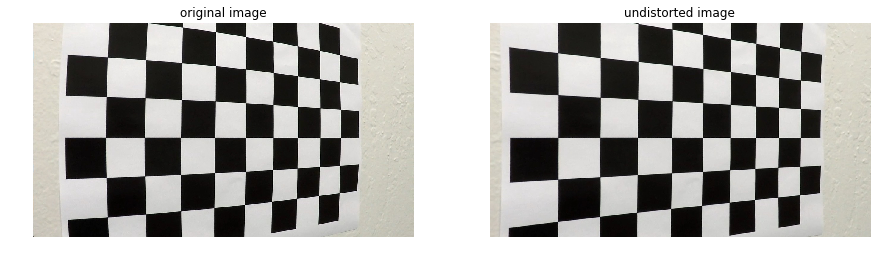

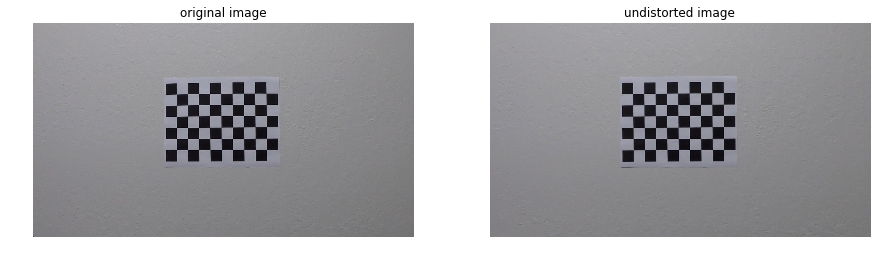

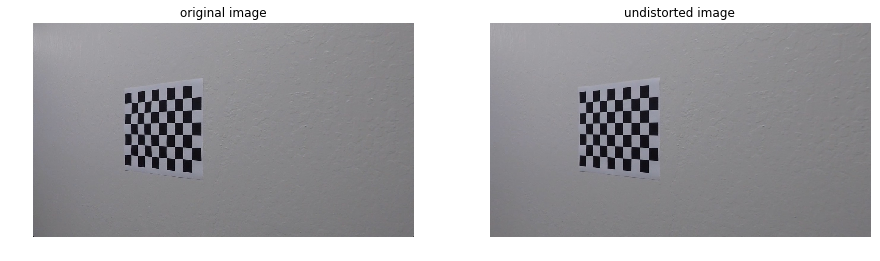

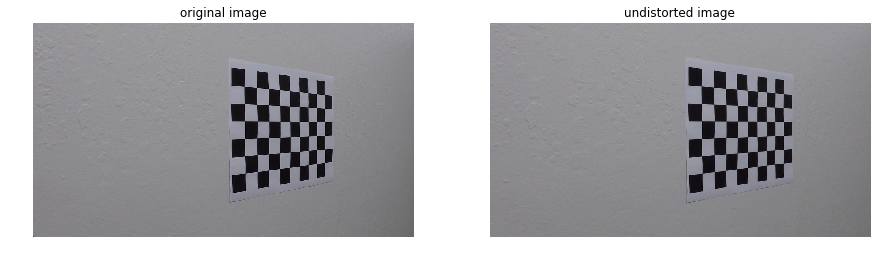

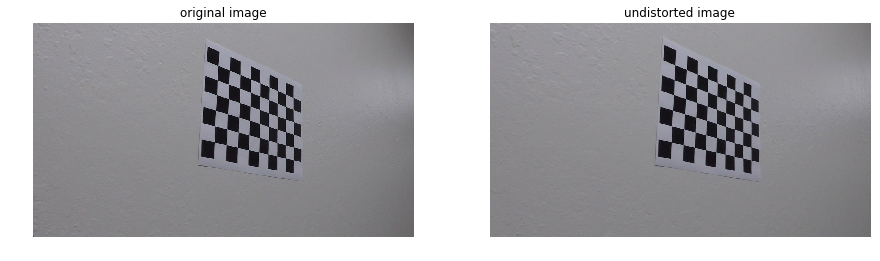

In [3]:
for fname in images:
    img = mpimg.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    plt.figure(figsize=(15,10))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('original image')
    plt.subplot(1,2,2)
    plt.imshow(dst)
    plt.axis('off')
    plt.title('undistorted image')

# Work on road images

### helper functions

In [4]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # recent polynomial coefficients
        self.recent_fit = []
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        # x values for detected line pixels
        self.allx = None  
        # y values for detected line pixels
        self.ally = None
        # counter to reset after 5 iterations if issues arise
        self.counter = 0
        
def perspective_transform(img, img_size, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, (img_size[1], img_size[0]), flags=cv2.INTER_LINEAR)
    return warped, M


def abs_sobel_thresh(img, orient='x', sobel_kernel=3 , thresh=(0, 255)):
    # Calculate directional gradient
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    absgraddir = np.arctan2(abs_sobelx , abs_sobely)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output


def bird_eye(image, mtx, dist, src, dst, s_thresh=(125,255), sx_thresh=(10,100), R_thresh = (200, 255)):
    
    ##################################
    
    sobel_kernel = 3
    distorted_img = np.copy(image)
    udist = cv2.undistort(distorted_img, mtx, dist, None, mtx)
    # Pull R
    R = udist[:,:,0]
    
    # Convert to HLS colorspace
    hls = cv2.cvtColor(udist, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobelx - takes the derivate in x, absolute value, then rescale
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= sx_thresh[0]) & (scaled_sobelx <= sx_thresh[1])] = 1

    # Threshold R color channel
    R_binary = np.zeros_like(R)
    R_binary[(R >= R_thresh[0]) & (R <= R_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # If two of the three are activated, activate in the binary image
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[((s_binary == 1) & (sxbinary == 1)) | ((sxbinary == 1) & (R_binary == 1))
                     | ((s_binary == 1) & (R_binary == 1))] = 1
    #plot
    plt.figure(figsize=(10,5))
    plt.imshow(combined_binary, cmap='gray')
    plt.title('combined binary')
    
    warped, M = perspective_transform(combined_binary, udist.shape, src, dst)
    
    return warped, M
    

def first_frame(img, mtx, dist, src, dst):
    
    binary_warped, perspective_M = bird_eye(img, mtx, dist, src, dst, s_thresh=(125,255), sx_thresh=(10,100), R_thresh = (200, 255))
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 8
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    # The challenge videos sometimes throw errors, so the below try first
    # Upon the error being thrown, set line.detected to False
    # Left line first
    try: 
        n = 10
        left_line.current_fit = np.polyfit(lefty, leftx, 2)
        left_line.all_x = leftx
        left_line.all_y = lefty
        left_line.recent_fit.append(left_line.current_fit)
        if len(left_line.recent_fit) > 1:
            left_line.diffs = (left_line.recent_fit[-2] - left_line.recent_fit[-1]) / left_line.recent_fit[-2]
        left_line.recent_fit = left_line.recent_fit[-n:]
        left_line.best_fit = np.mean(left_line.recent_fit, axis = 0)
        left_fit = left_line.current_fit
#         left_fit = left_line.best_fit
        left_line.detected = True
        left_line.counter = 0
    except TypeError:
        left_fit = left_line.best_fit
        left_line.detected = False
    except np.linalg.LinAlgError:
        left_fit = left_line.best_fit
        left_line.detected = False

    # Next, right line    
    try:
        n = 10
        right_line.current_fit = np.polyfit(righty, rightx, 2)
        right_line.all_x = rightx
        right_line.all_y = righty
        right_line.recent_fit.append(right_line.current_fit)
        if len(right_line.recent_fit) > 1:
            right_line.diffs = (right_line.recent_fit[-2] - right_line.recent_fit[-1]) / right_line.recent_fit[-2]
        right_line.recent_fit = right_line.recent_fit[-n:]
        right_line.best_fit = np.mean(right_line.recent_fit, axis = 0)
        right_fit = right_line.current_fit
#         right_fit = right_line.best_fit
        right_line.detected = True
        right_line.counter = 0
    except TypeError:
        right_fit = right_line.best_fit
        right_line.detected = False
    except np.linalg.LinAlgError:
        right_fit = right_line.best_fit
        right_line.detected = False
        
        
    ########### visualization ############    
    # Generate x and y values for plotting
    vis = False
    if vis:
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)

def second_ord_poly(line, val):
    return (line[0]*val**2)+(line[1]*val)+line[2]

def count_check(line):
    if line.counter >= 5:
        line.detected = False
        
def line_drawing(img, mtx, dist, src, dst):
    
    # Pull in the image
    binary_warped, perspective_M = bird_eye(img, mtx, dist, src, dst, s_thresh=(125,255), sx_thresh=(10,100), R_thresh = (200, 255))

    # Check if lines were last detected; if not, re-run first_frame
    if left_line.detected == False | right_line.detected == False:
        first_frame(img, mtx, dist, src, dst)

    # Set the fit as the current fit for now
    left_fit = left_line.current_fit
    right_fit = right_line.current_fit

    # Again, find the lane indicators
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Set the x and y values of points on each line
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each again.
    # Left line first
    try: 
        n = 10
        left_line.current_fit = np.polyfit(lefty, leftx, 2)
        left_line.all_x = leftx
        left_line.all_y = lefty
        left_line.recent_fit.append(left_line.current_fit)
        if len(left_line.recent_fit) > 1:
            left_line.diffs = (left_line.recent_fit[-2] - left_line.recent_fit[-1]) / left_line.recent_fit[-2]
        left_line.recent_fit = left_line.recent_fit[-n:]
        left_line.best_fit = np.mean(left_line.recent_fit, axis = 0)
        left_fit = left_line.current_fit
#         left_fit = left_line.best_fit
        left_line.detected = True
        left_line.counter = 0
    except TypeError:
        left_fit = left_line.best_fit
        count_check(left_line)
    except np.linalg.LinAlgError:
        left_fit = left_line.best_fit
        count_check(left_line)

    # Now right line    
    try:
        n = 10
        right_line.current_fit = np.polyfit(righty, rightx, 2)
        right_line.all_x = rightx
        right_line.all_y = righty
        right_line.recent_fit.append(right_line.current_fit)
        if len(right_line.recent_fit) > 1:
            right_line.diffs = (right_line.recent_fit[-2] - right_line.recent_fit[-1]) / right_line.recent_fit[-2]
        right_line.recent_fit = right_line.recent_fit[-n:]
        right_line.best_fit = np.mean(right_line.recent_fit, axis = 0)
        right_fit = right_line.current_fit
#         right_fit = right_line.best_fit
        right_line.detected = True
        right_line.counter = 0
    except TypeError:
        right_fit = right_line.best_fit
        count_check(right_line)
    except np.linalg.LinAlgError:
        right_fit = right_line.best_fit
        count_check(right_line)

    # Generate x and y values for plotting
    fity = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    fit_leftx = left_fit[0]*fity**2 + left_fit[1]*fity + left_fit[2]
    fit_rightx = right_fit[0]*fity**2 + right_fit[1]*fity + right_fit[2]

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)

    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([fit_leftx-margin, fity]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([fit_leftx+margin, fity])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([fit_rightx-margin, fity]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([fit_rightx+margin, fity])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # visualize
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(fit_leftx, fity, color='yellow')
    plt.plot(fit_rightx, fity, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    # Calculate the pixel curve radius
    y_eval = np.max(fity)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
#     print('left_curve:', left_curverad)
#     print('right curve:', right_curverad)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(left_line.all_y*ym_per_pix, left_line.all_x*xm_per_pix, 2)
    right_fit_cr = np.polyfit(right_line.all_y*ym_per_pix, right_line.all_x*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
#     print(left_curverad, 'm', right_curverad, 'm')
    avg_rad = round(np.mean([left_curverad, right_curverad]),0)
    rad_text = "Radius of Curvature = {}(m)".format(avg_rad)

    # Calculating middle of the image, aka where the car camera is
    middle_of_image = img.shape[1] / 2
    car_position = middle_of_image * xm_per_pix

    # Calculating middle of the lane
    left_line_base = second_ord_poly(left_fit_cr, img.shape[0] * ym_per_pix)
    right_line_base = second_ord_poly(right_fit_cr, img.shape[0] * ym_per_pix)
    lane_mid = (left_line_base+right_line_base)/2

    # Calculate distance from center and list differently based on left or right
    dist_from_center = lane_mid - car_position
    if dist_from_center >= 0:
        center_text = "{} meters left of center".format(round(dist_from_center,2))
    else:
        center_text = "{} meters right of center".format(round(-dist_from_center,2))
        
    # List car's position in relation to middle on the image and radius of curvature
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img, center_text, (10,50), font, 1,(255,255,255),2)
    cv2.putText(img, rad_text, (10,100), font, 1,(255,255,255),2)

    # Invert the transform matrix from birds_eye (to later make the image back to normal below)
    Minv = np.linalg.inv(perspective_M)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([fit_leftx, fity]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([fit_rightx, fity])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,200, 1000))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))
    
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)

    return result

def pipeline(image):
    
    result = line_drawing(image, mtx, dist , src, dst)
    
    return result

### load image

C:\Users\Isaac\Documents\miniconda3\envs\carnd-term1\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


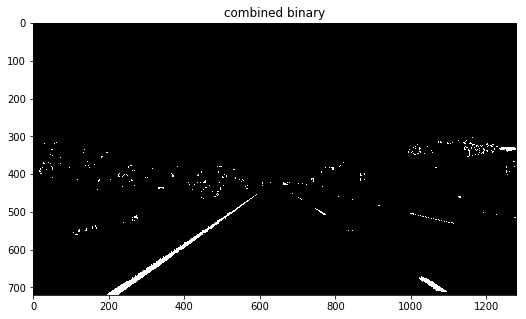

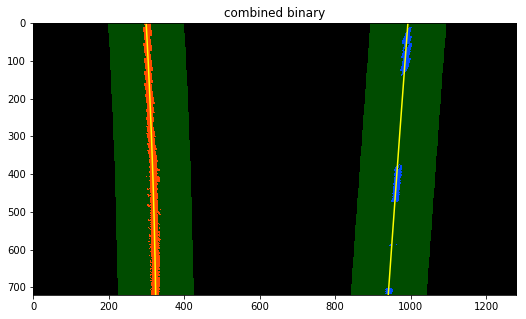

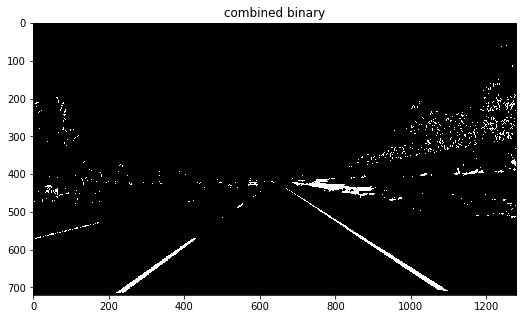

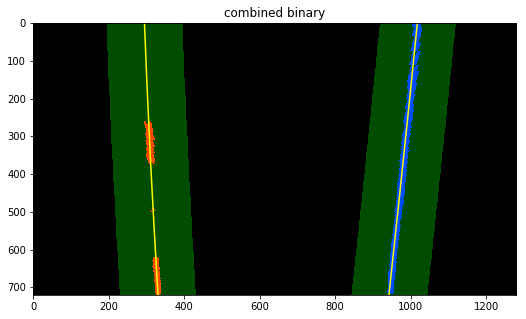

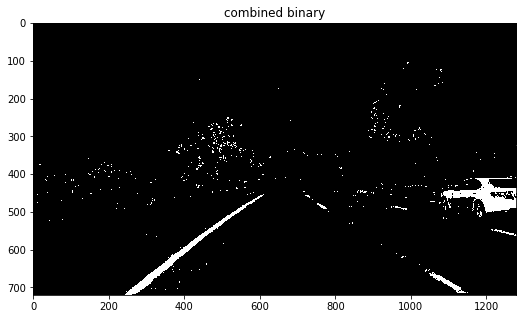

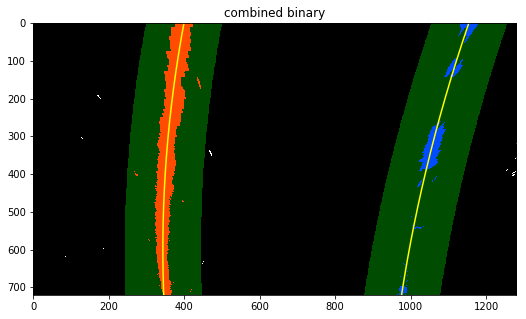

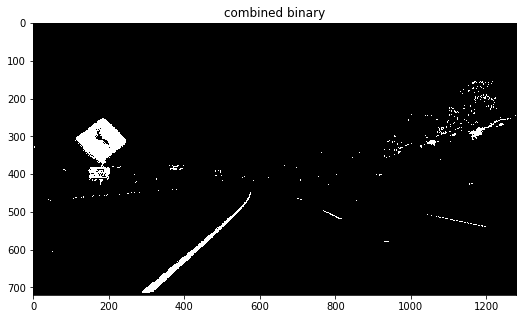

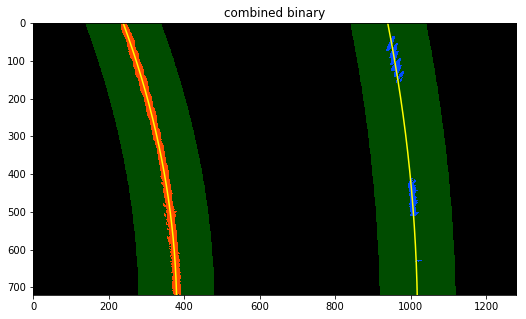

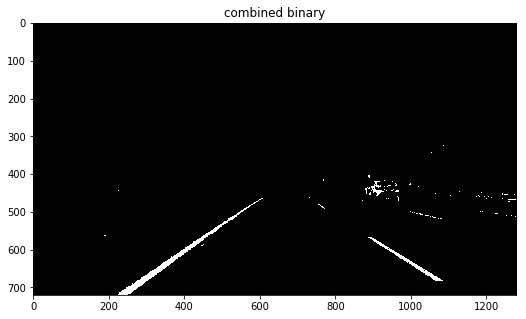

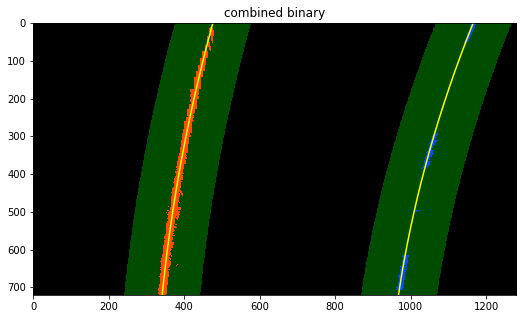

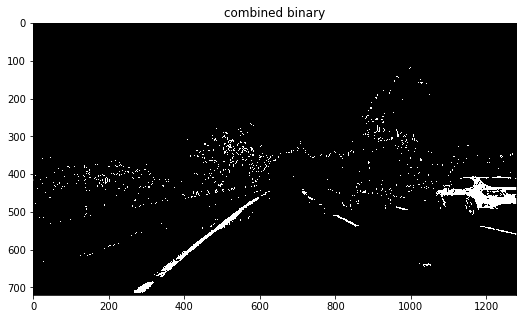

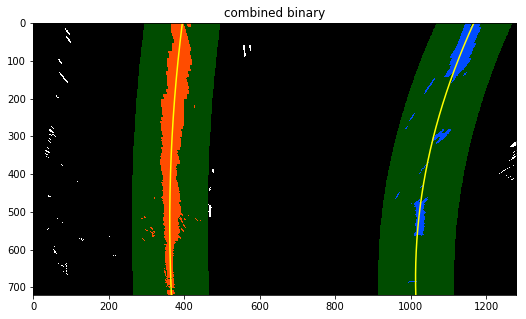

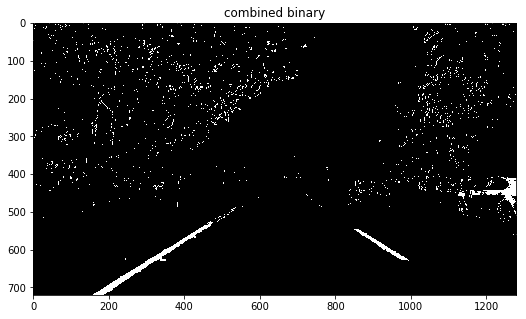

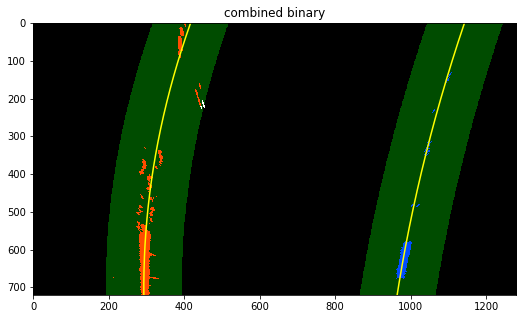

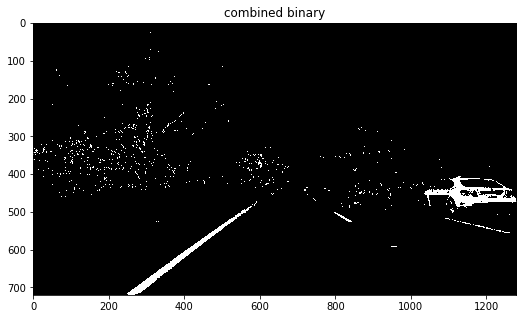

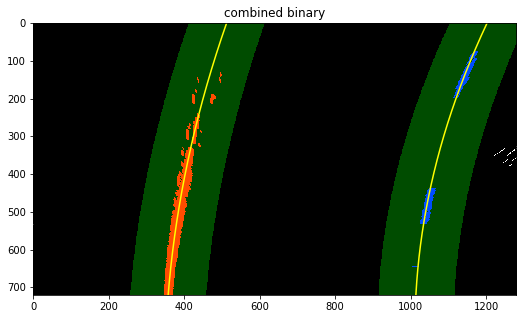

In [5]:
images = glob.glob('test_images/*.jpg')
for fname in images:
    
    plt.figure(figsize=(15,10))

    img = mpimg.imread(fname)
#     plt.subplot(1,2,1)
#     plt.imshow(img)
#     plt.title('original image')
  
    img_size = img.shape
    
    src = np.float32(
    [[(img_size[1] / 2) - 55, img_size[0] / 2 + 100],
    [((img_size[1] / 6) - 10), img_size[0]],
    [(img_size[1] * 5 / 6) + 60, img_size[0]],
    [(img_size[1] / 2 + 55), img_size[0] / 2 + 100]])
    dst = np.float32(
    [[(img_size[1] / 4), 0],
    [(img_size[1] / 4), img_size[0]],
    [(img_size[1] * 3 / 4), img_size[0]],
    [(img_size[1] * 3 / 4), 0]])

    img = cv2.undistort(img, mtx, dist, None, mtx)
#     plt.subplot(1,2,1)
#     plt.imshow(img)
#     plt.title('undistorted image')  
#     for i in range(4):
#         plt.plot(src[i,0], src[i,1], 's r')
    
#     warped, M = perspective_transform(img, img.shape, src, dst)
#     plt.subplot(1,2,2)
#     plt.imshow(warped)
#     plt.title('bird_eye view')
#     for i in range(4):
#         plt.plot(dst[i,0], dst[i,1], 's r')
    
    left_line = Line()
    right_line = Line()
    
    result = line_drawing(img, mtx, dist, src, dst)
    
#     plt.figure(figsize=(10,5))
#     plt.imshow(result)
#     plt.title('final result')
    
    

In [6]:
src

array([[  585.        ,   460.        ],
       [  203.33332825,   720.        ],
       [ 1126.66662598,   720.        ],
       [  695.        ,   460.        ]], dtype=float32)

In [7]:
dst

array([[ 320.,    0.],
       [ 320.,  720.],
       [ 960.,  720.],
       [ 960.,    0.]], dtype=float32)